
# Notebook 03: Normalization, PCA, and Modeling Readiness

## Why this notebook matters

Notebook 02 gave us a strong feature set. This notebook prepares that feature set for clustering by:
- putting all features on comparable scale,
- compressing high-dimensional aisle behavior,
- preserving behavioral features needed for interpretation,
- and creating a rigor path (full vs pruned behavioral variants) for fair model comparison.

Main question:
**Can we build a stable, clustering-ready representation without losing the behavioral signal we care about?**



---

## Setup

Load dependencies, set reproducibility defaults, and configure paths.


In [20]:

# Standard library imports
import json
import pickle
import warnings
from pathlib import Path
from typing import Tuple, List

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import sklearn

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Configuration
warnings.simplefilter('default')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Directories
FEATURES_DIR = Path('data/features')
OUTPUT_DIR = Path('data/processed_features')
VIZ_DIR = Path('visualizations')

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
VIZ_DIR.mkdir(parents=True, exist_ok=True)

print('Environment ready.')
print(f'sklearn version: {sklearn.__version__}')
print(f'Random seed: {RANDOM_SEED}')
print(f'Input directory: {FEATURES_DIR}')
print(f'Output directory: {OUTPUT_DIR}')
print(f'Visualization directory: {VIZ_DIR}')


Environment ready.
sklearn version: 1.6.1
Random seed: 42
Input directory: data/features
Output directory: data/processed_features
Visualization directory: visualizations



---

## 1) Load Feature Matrix from Notebook 02

Load the cleaned feature matrix and run mandatory preflight checks.


In [21]:
# Load the feature matrix created in Notebook 02
# This contains 149 features: 135 aisle preferences + 14 behavioral metrics
print("Loading feature matrix from Notebook 02...")

feature_matrix = pd.read_parquet(FEATURES_DIR / 'feature_matrix.parquet')

print(f"\n✅ Feature matrix loaded:")
print(f"   Shape: {feature_matrix.shape}")
print(f"   Users: {len(feature_matrix):,}")
print(f"   Features: {len(feature_matrix.columns)}")
print(f"   Memory: {feature_matrix.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Critical validation: Check for missing values
# PCA cannot handle NaN values - must be zero
missing_count = feature_matrix.isnull().sum().sum()
assert missing_count == 0, f"Found {missing_count} missing values!"
print(f"   Missing values: {missing_count} ✓")

# Convert all features to float64 for consistency with sklearn
# This is safe even if already float64 and handles int64, etc.
if not all(feature_matrix.dtypes == 'float64'):
    print(f"   Converting data types to float64...")
    feature_matrix = feature_matrix.astype('float64')
print(f"   Data types: All float64 ✓")

Loading feature matrix from Notebook 02...

✅ Feature matrix loaded:
   Shape: (182223, 149)
   Users: 182,223
   Features: 149
   Memory: 208.54 MB
   Missing values: 0 ✓
   Converting data types to float64...
   Data types: All float64 ✓



---

## 2) Split Aisle vs Behavioral Features

Aisle features are high-dimensional and sparse, so we reduce them with PCA.
Behavioral features stay explicit so downstream segments remain interpretable.


In [22]:
print("Separating feature types...")

# Identify aisle features by naming convention
# All aisle features start with 'aisle_'
aisle_features: List[str] = [col for col in feature_matrix.columns if col.startswith('aisle_')]

# All non-aisle features are behavioral
behavioral_features: List[str] = [col for col in feature_matrix.columns if not col.startswith('aisle_')]

# Create separate matrices for each feature type
# Use .copy() to avoid SettingWithCopyWarning
aisle_matrix: pd.DataFrame = feature_matrix[aisle_features].copy()
behavioral_matrix: pd.DataFrame = feature_matrix[behavioral_features].copy()

print(f"\n📊 Feature separation:")
print(f"   Aisle features:      {len(aisle_features)} (will apply PCA)")
print(f"   Behavioral features: {len(behavioral_features)} (will keep as-is)")

# Display behavioral features for reference
print(f"\nBehavioral features:")
for feat in behavioral_features:
    print(f"   - {feat}")

# Validation: Ensure no overlap and complete coverage
assert len(set(aisle_features) & set(behavioral_features)) == 0, "Features overlap!"
assert len(aisle_features) + len(behavioral_features) == len(feature_matrix.columns), "Features missing!"
print(f"\n✅ Feature separation validated")

Separating feature types...

📊 Feature separation:
   Aisle features:      135 (will apply PCA)
   Behavioral features: 14 (will keep as-is)

Behavioral features:
   - reorder_ratio
   - reorder_consistency
   - pct_reordered_products
   - mean_days_between_orders
   - cv_days_between_orders
   - mean_order_hour
   - std_order_hour
   - avg_basket_size
   - std_basket_size
   - min_basket_size
   - max_basket_size
   - basket_size_cv
   - unique_products
   - unique_aisles

✅ Feature separation validated



---

## 3) Standardize Features

Scale all inputs before PCA/clustering so distance-based methods are not dominated by raw magnitude differences.


In [23]:
def apply_standard_scaler(
    data: pd.DataFrame
) -> Tuple[pd.DataFrame, StandardScaler]:
    """
    Apply StandardScaler to transform features to mean=0, std=1.
    
    Args:
        data: DataFrame with raw features
        
    Returns:
        Tuple of (scaled DataFrame, fitted scaler model)
    """
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit and transform
    # fit(): Learns mean and std for each feature
    # transform(): Applies z = (x - mean) / std
    scaled_array = scaler.fit_transform(data)
    
    # Convert back to DataFrame to preserve index and column names
    scaled_df = pd.DataFrame(
        scaled_array,
        index=data.index,
        columns=data.columns
    )
    
    return scaled_df, scaler


print("Applying StandardScaler to all features...")

# Scale all 149 features together for consistency
scaled_features_df, scaler = apply_standard_scaler(feature_matrix)

print(f"\n✅ Scaling complete.")
print(f"   Shape: {scaled_features_df.shape}")

# Comprehensive validation
print(f"\n🔍 Validation:")

# Check 1: Mean of each feature should be ~0
means = scaled_features_df.mean()
print(f"   Mean of means: {means.mean():.6f} (should be ≈ 0)")
print(f"   Max absolute mean: {means.abs().max():.6f} (should be < 0.001)")

# Check 2: Std of each feature should be ~1
stds = scaled_features_df.std()
print(f"   Mean of stds: {stds.mean():.6f} (should be ≈ 1)")
print(f"   Min std: {stds.min():.6f}")
print(f"   Max std: {stds.max():.6f}")

# Check 3: No NaNs or Infs
has_nan = scaled_features_df.isnull().sum().sum()
has_inf = np.isinf(scaled_features_df).sum().sum()
print(f"   NaNs: {has_nan}")
print(f"   Infs: {has_inf}")

# Assertions for critical checks
assert means.abs().max() < 0.001, "Features not properly centered!"
assert has_nan == 0, "NaN values detected after scaling!"
assert has_inf == 0, "Inf values detected after scaling!"

print(f"\n✅ Scaling validation passed.")

Applying StandardScaler to all features...

✅ Scaling complete.
   Shape: (182223, 149)

🔍 Validation:
   Mean of means: 0.000000 (should be ≈ 0)
   Max absolute mean: 0.000000 (should be < 0.001)
   Mean of stds: 1.000003 (should be ≈ 1)
   Min std: 1.000003
   Max std: 1.000003
   NaNs: 0
   Infs: 0

✅ Scaling validation passed.



---

## 4) PCA on Aisle Block

Apply PCA only to aisle features (the sparse high-dimensional block).
Behavioral features are kept outside PCA to retain direct business meaning.


In [24]:
# First, separate scaled aisles from scaled behavioral
scaled_aisles: pd.DataFrame = scaled_features_df[aisle_features].copy()
scaled_behavioral: pd.DataFrame = scaled_features_df[behavioral_features].copy()

print("Separated scaled features:")
print(f"  Scaled aisles shape: {scaled_aisles.shape}")
print(f"  Scaled behavioral shape: {scaled_behavioral.shape}")

Separated scaled features:
  Scaled aisles shape: (182223, 135)
  Scaled behavioral shape: (182223, 14)


In [25]:
def apply_pca(
    data: pd.DataFrame,
    n_components: int = 50,
    random_state: int = 42
) -> Tuple[pd.DataFrame, PCA]:
    """
    Apply PCA for dimensionality reduction.
    
    Args:
        data: Scaled features (mean=0, std=1)
        n_components: Number of principal components to retain
        random_state: Random seed for reproducibility
        
    Returns:
        Tuple of (transformed DataFrame, fitted PCA model)
    """
    # Initialize PCA
    pca = PCA(n_components=n_components, random_state=random_state)
    
    # Fit and transform
    # fit(): Computes eigenvectors and eigenvalues
    # transform(): Projects data onto principal components
    pca_array = pca.fit_transform(data)
    
    # Convert to DataFrame
    pca_df = pd.DataFrame(
        pca_array,
        index=data.index,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )
    
    return pca_df, pca


# First fit with all components to analyze variance
print("Fitting PCA with all components for variance analysis...")
_, pca_full = apply_pca(scaled_aisles, n_components=len(aisle_features))

# Get variance explained
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\n✅ Full PCA fitted (all {len(aisle_features)} components)")
print(f"\n🔍 Variance explained:")
print(f"   PC1-10:  {cumulative_variance[9]*100:.2f}%")
print(f"   PC1-20:  {cumulative_variance[19]*100:.2f}%")
print(f"   PC1-30:  {cumulative_variance[29]*100:.2f}%")
print(f"   PC1-40:  {cumulative_variance[39]*100:.2f}%")
print(f"   PC1-50:  {cumulative_variance[49]*100:.2f}%")

print(f"\n   Individual components:")
for i in range(min(5, len(explained_variance_ratio))):
    print(f"   PC{i+1}:  {explained_variance_ratio[i]*100:.2f}%")
print(f"   ...")
print(f"   PC50: {explained_variance_ratio[49]*100:.2f}%")

Fitting PCA with all components for variance analysis...

✅ Full PCA fitted (all 135 components)

🔍 Variance explained:
   PC1-10:  14.93%
   PC1-20:  23.92%
   PC1-30:  31.86%
   PC1-40:  39.38%
   PC1-50:  46.68%

   Individual components:
   PC1:  2.67%
   PC2:  2.18%
   PC3:  1.81%
   PC4:  1.43%
   PC5:  1.27%
   ...
   PC50: 0.72%


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountere

### Visualize Variance Explained

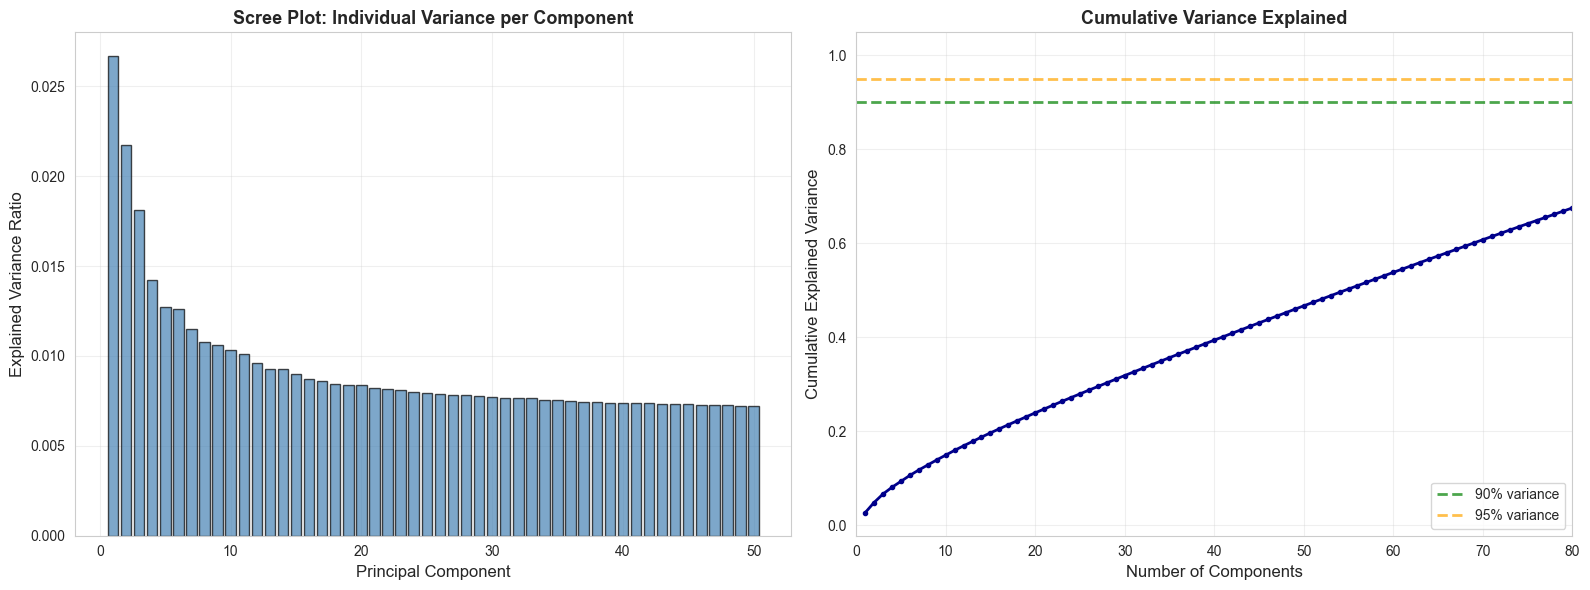


✅ Variance plot saved: 01_pca_variance_explained.png

💡 Interpretation:
   - Early components carry more variance than later ones, but there is no sharp elbow.
   - At 50 components, cumulative variance is 46.68% in this run.
   - 90%/95% variance thresholds are not reached in the displayed range.


In [26]:
# Create comprehensive variance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scree plot (individual variance per component)
n_display = min(50, len(explained_variance_ratio))
axes[0].bar(
    range(1, n_display+1),
    explained_variance_ratio[:n_display],
    alpha=0.7,
    color='steelblue',
    edgecolor='black'
)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('Scree Plot: Individual Variance per Component',
                  fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Cumulative variance
axes[1].plot(
    range(1, len(cumulative_variance)+1),
    cumulative_variance,
    linewidth=2,
    color='darkblue',
    marker='o',
    markersize=3
)
# Add reference lines for common thresholds
axes[1].axhline(0.90, color='green', linestyle='--', linewidth=2,
                alpha=0.7, label='90% variance')
axes[1].axhline(0.95, color='orange', linestyle='--', linewidth=2,
                alpha=0.7, label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Variance Explained',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].set_xlim(0, min(80, len(cumulative_variance)))

plt.tight_layout()
plt.savefig(VIZ_DIR / '01_pca_variance_explained.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Variance plot saved: 01_pca_variance_explained.png")

print("\n💡 Interpretation:")

print("   - Early components carry more variance than later ones, but there is no sharp elbow.")
print(f"   - At 50 components, cumulative variance is {cumulative_variance[49]*100:.2f}% in this run.")
print("   - 90%/95% variance thresholds are not reached in the displayed range.")



### Select Number of Components

Component count is chosen using a practical tradeoff:
- variance retained,
- total dimensionality for clustering,
- and downstream interpretability.


In [27]:

print('=' * 70)
print('COMPONENT SELECTION DECISION')
print('=' * 70)

candidate_components = [30, 40, 50, 60, 70]
rows = []
for n_comp in candidate_components:
    if n_comp <= len(cumulative_variance):
        rows.append({
            'n_components': n_comp,
            'variance_retained_pct': cumulative_variance[n_comp - 1] * 100,
            'total_features_after_merge': n_comp + len(behavioral_features),
        })

selection_df = pd.DataFrame(rows)
print()
print('Candidate comparison:')
print(selection_df.to_string(index=False, float_format=lambda x: f'{x:.2f}'))

N_COMPONENTS = 50
selected_row = selection_df[selection_df['n_components'] == N_COMPONENTS].iloc[0]

print()
print('Decision rationale:')
print(f"  Selected components: {N_COMPONENTS}")
print(f"  Variance retained: {selected_row['variance_retained_pct']:.2f}%")
print(f"  Final features after merge: {int(selected_row['total_features_after_merge'])}")
print('  This keeps representation compact while preserving enough variance for cluster testing.')


COMPONENT SELECTION DECISION

Candidate comparison:
 n_components  variance_retained_pct  total_features_after_merge
           30                  31.86                          44
           40                  39.38                          54
           50                  46.68                          64
           60                  53.80                          74
           70                  60.75                          84

Decision rationale:
  Selected components: 50
  Variance retained: 46.68%
  Final features after merge: 64
  This keeps representation compact while preserving enough variance for cluster testing.


### Refit PCA with Selected Components

In [28]:
print(f"\nRefitting PCA with {N_COMPONENTS} components...")

# Apply PCA with selected number of components
pca_df_final, pca_final = apply_pca(scaled_aisles, n_components=N_COMPONENTS)

print(f"\n✅ PCA transformation complete.")
print(f"   Shape: {pca_df_final.shape}")
print(f"   Variance explained: {pca_final.explained_variance_ratio_.sum()*100:.2f}%")

# Validation
print(f"\n🔍 PCA validation:")
print(f"   NaNs: {pca_df_final.isnull().sum().sum()}")
print(f"   Infs: {np.isinf(pca_df_final).sum().sum()}")
print(f"   Mean (should be ~0): {pca_df_final.mean().mean():.6f}")
print(f"   Std (should be ~1): {pca_df_final.std().mean():.6f}")

assert pca_df_final.isnull().sum().sum() == 0, "NaN values in PCA output!"
assert np.isinf(pca_df_final).sum().sum() == 0, "Inf values in PCA output!"

print(f"\n✅ PCA validation passed.")


Refitting PCA with 50 components...

✅ PCA transformation complete.
   Shape: (182223, 50)
   Variance explained: 46.68%

🔍 PCA validation:
   NaNs: 0
   Infs: 0
   Mean (should be ~0): -0.000000
   Std (should be ~1): 1.107481

✅ PCA validation passed.


/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/adeliaramp/Documents/instacart-customer-segmentation-clean/.venv/lib/python3.9/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountere


---

## 5) PC Loadings Interpretation

Use loadings to understand what each principal component is capturing behaviorally.


In [29]:
def analyze_pc_loadings(
    pca_model: PCA,
    feature_names: List[str],
    n_top: int = 10
) -> pd.DataFrame:
    """
    Extract and analyze PC loadings.
    
    Args:
        pca_model: Fitted PCA model
        feature_names: Original feature names
        n_top: Number of top features to display per PC
        
    Returns:
        DataFrame with loadings (features × PCs)
    """
    # Extract loadings from PCA
    # components_ shape: (n_components, n_features)
    # We transpose to get (n_features, n_components)
    loadings = pd.DataFrame(
        pca_model.components_.T,
        index=feature_names,
        columns=[f'PC{i+1}' for i in range(pca_model.n_components_)]
    )
    
    return loadings


print("Analyzing PC loadings...")

# Get loadings matrix
loadings_df = analyze_pc_loadings(pca_final, aisle_features)

print(f"\n✅ Loadings matrix created: {loadings_df.shape}")
print(f"   Features (aisles): {len(aisle_features)}")
print(f"   Components: {N_COMPONENTS}")

# Analyze first 3 PCs in detail
for pc_num in range(1, min(4, N_COMPONENTS+1)):
    pc_name = f'PC{pc_num}'
    variance_pct = pca_final.explained_variance_ratio_[pc_num-1] * 100
    
    print(f"\n{'='*60}")
    print(f"{pc_name} Analysis (explains {variance_pct:.2f}% of variance)")
    print(f"{'='*60}")
    
    # Top 10 positive loadings
    top_positive = loadings_df[pc_name].nlargest(10)
    print(f"\nTop 10 Positive Loadings (aisles that define {pc_name}):")
    for i, (aisle, loading) in enumerate(top_positive.items(), 1):
        print(f"  {i:2d}. {aisle:30s} {loading:>7.4f}")
    
    # Top 10 negative loadings
    top_negative = loadings_df[pc_name].nsmallest(10)
    print(f"\nTop 10 Negative Loadings (opposite direction):")
    for i, (aisle, loading) in enumerate(top_negative.items(), 1):
        print(f"  {i:2d}. {aisle:30s} {loading:>7.4f}")
    
    print(f"\n💡 Interpretation:")
    print(f"   High PC{pc_num} score → Preference for positive-loading aisles")
    print(f"   Low PC{pc_num} score → Preference for negative-loading aisles")

# Save loadings to CSV for further analysis
loadings_df.to_csv(OUTPUT_DIR / 'pca_loadings.csv')
print(f"\n✅ Loadings saved: pca_loadings.csv")

Analyzing PC loadings...

✅ Loadings matrix created: (135, 50)
   Features (aisles): 135
   Components: 50

PC1 Analysis (explains 2.67% of variance)

Top 10 Positive Loadings (aisles that define PC1):
   1. aisle_83_fresh vegetables       0.3058
   2. aisle_123_packaged vegetables fruits  0.2075
   3. aisle_16_fresh herbs            0.1896
   4. aisle_24_fresh fruits           0.1885
   5. aisle_81_canned jarred vegetables  0.1323
   6. aisle_59_canned meals beans     0.1017
   7. aisle_116_frozen produce        0.1002
   8. aisle_63_grains rice dried goods  0.0974
   9. aisle_122_meat counter          0.0929
  10. aisle_35_poultry counter        0.0893

Top 10 Negative Loadings (opposite direction):
   1. aisle_54_paper goods           -0.2414
   2. aisle_114_cleaning products    -0.2288
   3. aisle_127_body lotions soap    -0.2121
   4. aisle_20_oral hygiene          -0.1904
   5. aisle_75_laundry               -0.1903
   6. aisle_74_dish detergents       -0.1703
   7. aisle_77_soft

### Visualize Loadings Heatmap

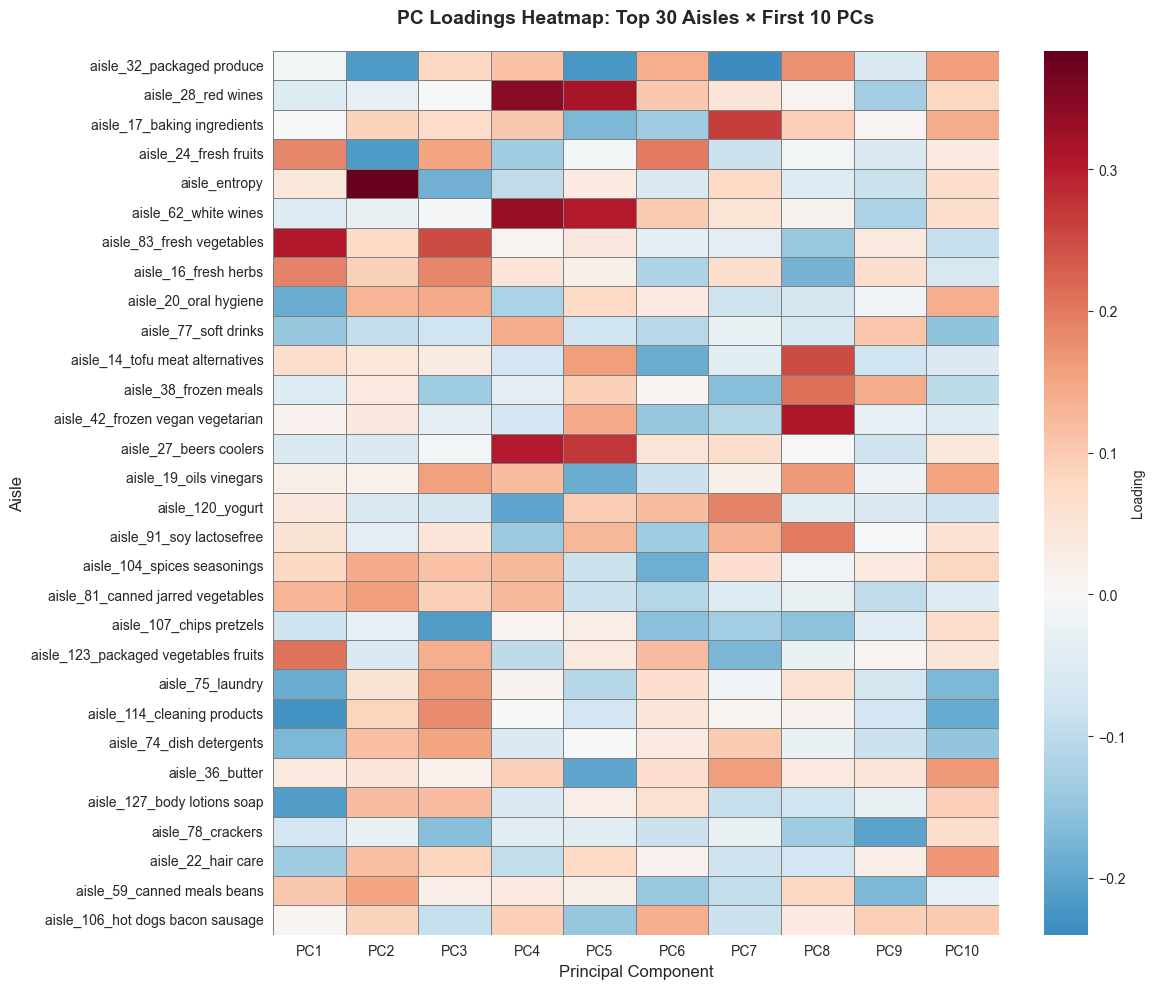


✅ Loadings heatmap saved: 02_pca_loadings_heatmap.png

💡 Reading the heatmap:
   - Red: Positive loading (aisle defines PC positively)
   - Blue: Negative loading (aisle defines PC negatively)
   - White: Near-zero loading (aisle doesn't contribute)


In [30]:
# Create loadings heatmap for first 10 PCs and top 30 aisles
fig, ax = plt.subplots(figsize=(12, 10))

# Select top aisles by total absolute loading across first 10 PCs
top_aisles_idx = loadings_df.iloc[:, :10].abs().sum(axis=1).nlargest(30).index
loadings_subset = loadings_df.loc[top_aisles_idx, [f'PC{i}' for i in range(1, 11)]]

# Create heatmap
sns.heatmap(
    loadings_subset,
    cmap='RdBu_r',
    center=0,
    cbar_kws={'label': 'Loading'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)
ax.set_title('PC Loadings Heatmap: Top 30 Aisles × First 10 PCs',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Principal Component', fontsize=12)
ax.set_ylabel('Aisle', fontsize=12)

plt.tight_layout()
plt.savefig(VIZ_DIR / '02_pca_loadings_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Loadings heatmap saved: 02_pca_loadings_heatmap.png")
print("\n💡 Reading the heatmap:")
print("   - Red: Positive loading (aisle defines PC positively)")
print("   - Blue: Negative loading (aisle defines PC negatively)")
print("   - White: Near-zero loading (aisle doesn't contribute)")


---

## 6) Feature Importance from PCA Loadings

Rank aisles by weighted loading magnitude to identify which categories drive most variance.


In [31]:
def calculate_feature_importance(
    loadings: pd.DataFrame,
    variance_explained: np.ndarray
) -> pd.DataFrame:
    """
    Calculate feature importance based on weighted loadings.
    
    Args:
        loadings: DataFrame of PC loadings
        variance_explained: Array of variance explained per PC
        
    Returns:
        DataFrame with importance scores sorted descending
    """
    # Weight loadings by variance explained
    # Features that load heavily on high-variance PCs are more important
    weighted_loadings = loadings.abs().mul(variance_explained, axis=1)
    
    # Sum across all PCs
    importance = weighted_loadings.sum(axis=1)
    
    # Create DataFrame and sort
    importance_df = pd.DataFrame({
        'aisle': importance.index,
        'importance_score': importance.values,
        'rank': range(1, len(importance) + 1)
    }).sort_values('importance_score', ascending=False).reset_index(drop=True)
    
    importance_df['rank'] = range(1, len(importance_df) + 1)
    
    return importance_df


print("Calculating feature importance...")

# Calculate importance
feature_importance = calculate_feature_importance(
    loadings_df,
    pca_final.explained_variance_ratio_
)

print(f"\n✅ Feature importance calculated")
print(f"\nTop 20 Most Important Aisles:")
print(feature_importance.head(20).to_string(index=False))

print(f"\nBottom 10 Least Important Aisles:")
print(feature_importance.tail(10).to_string(index=False))

# Save to CSV
feature_importance.to_csv(OUTPUT_DIR / 'feature_importance.csv', index=False)
print(f"\n✅ Feature importance saved: feature_importance.csv")

print(f"\n💡 Interpretation:")
print(f"   - High importance: These aisles drive customer segmentation")
print(f"   - Low importance: Rare aisles with minimal clustering impact")
print(f"   - Use this to guide business strategy and marketing")

Calculating feature importance...

✅ Feature importance calculated

Top 20 Most Important Aisles:
                                  aisle  importance_score  rank
                  aisle_7_packaged meat          0.036456     1
                      aisle_100_missing          0.036301     2
  aisle_68_bulk grains rice dried goods          0.036226     3
aisle_115_water seltzer sparkling water          0.035998     4
                       aisle_120_yogurt          0.035923     5
                  aisle_76_indian foods          0.035722     6
           aisle_103_ice cream toppings          0.035550     7
                          aisle_84_milk          0.034641     8
                    aisle_43_buns rolls          0.034597     9
                    aisle_9_pasta sauce          0.034595    10
                          aisle_86_eggs          0.034402    11
               aisle_39_seafood counter          0.034372    12
                  aisle_33_kosher foods          0.034286    13
 aisle

### Visualize Feature Importance

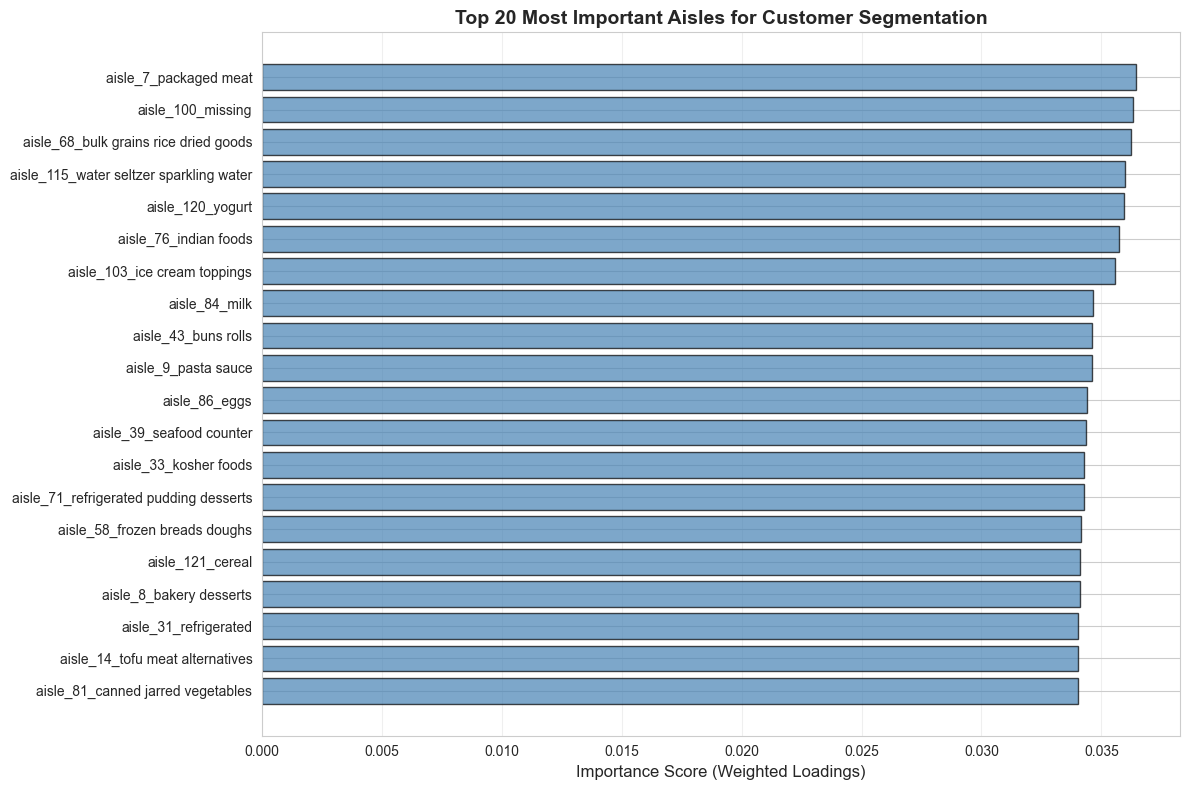


✅ Feature importance plot saved: 03_feature_importance.png


In [32]:
# Create bar chart of top 20 most important aisles
fig, ax = plt.subplots(figsize=(12, 8))

top_20 = feature_importance.head(20)
ax.barh(
    range(len(top_20)),
    top_20['importance_score'],
    color='steelblue',
    edgecolor='black',
    alpha=0.7
)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['aisle'])
ax.invert_yaxis()
ax.set_xlabel('Importance Score (Weighted Loadings)', fontsize=12)
ax.set_title('Top 20 Most Important Aisles for Customer Segmentation',
             fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(VIZ_DIR / '03_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance plot saved: 03_feature_importance.png")


---

## 7) PCA Space Visualization

Visual diagnostics to understand structure quality before clustering.


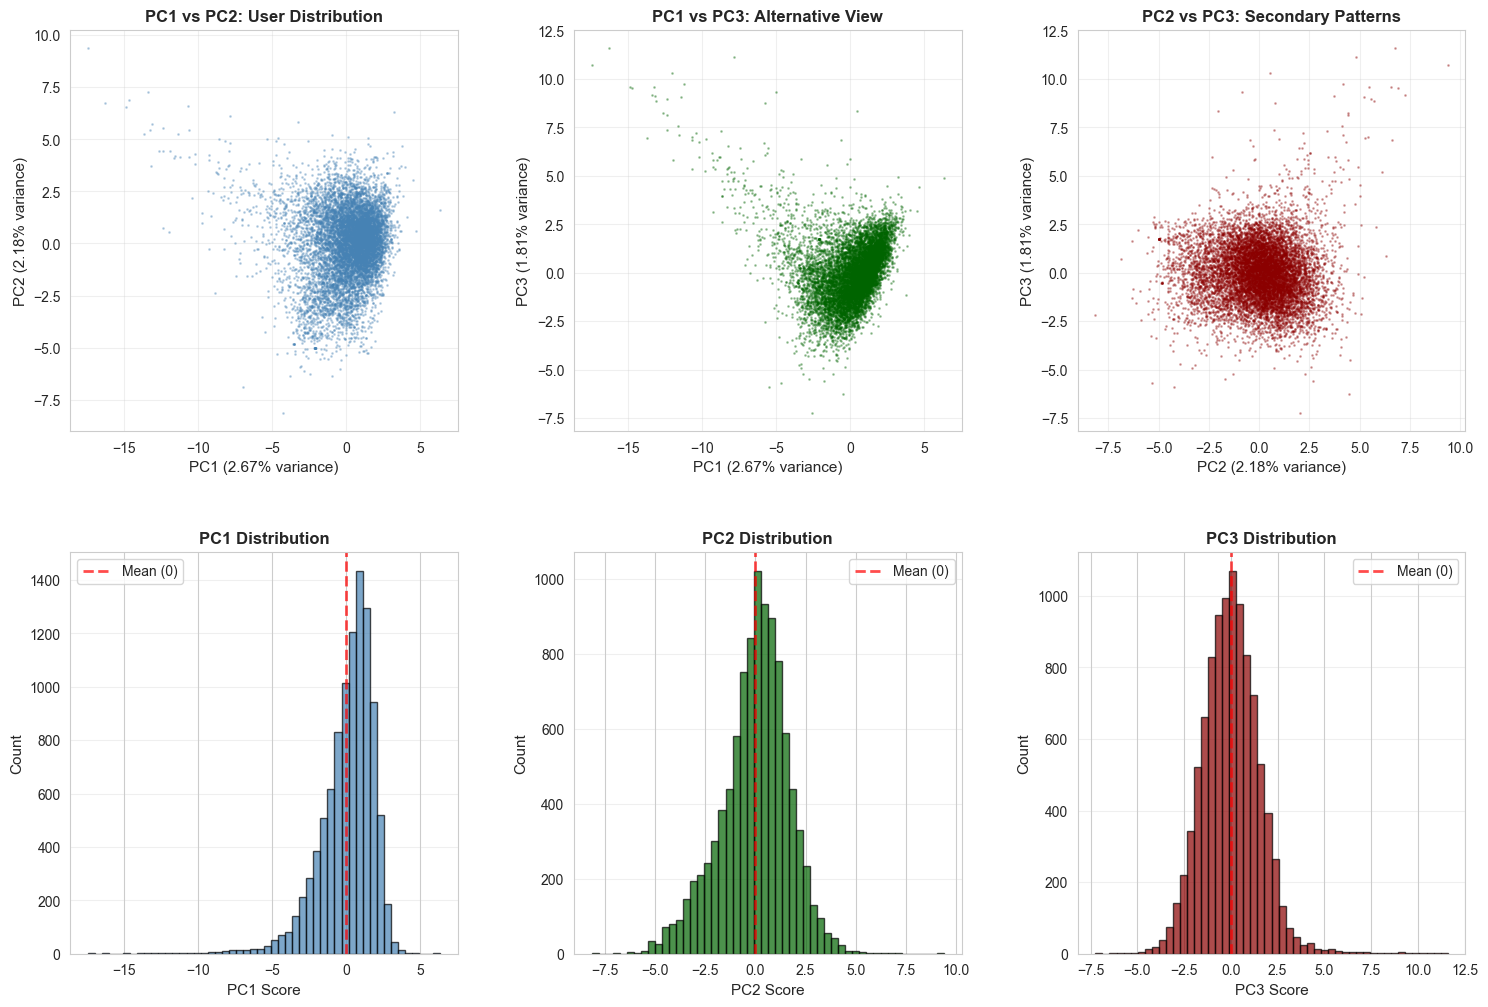


✅ 2D PC visualization saved: 04_pca_2d_visualization.png


In [33]:

# Create comprehensive 2D/3D visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Sample data for visualization (too many points = cluttered)
n_sample = min(10000, len(pca_df_final))
rng = np.random.default_rng(RANDOM_SEED)
sample_idx = rng.choice(len(pca_df_final), n_sample, replace=False)
pca_sample = pca_df_final.iloc[sample_idx]

# Plot 1: PC1 vs PC2
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(pca_sample['PC1'], pca_sample['PC2'], alpha=0.3, s=1, c='steelblue')
ax1.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax1.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax1.set_title('PC1 vs PC2: User Distribution', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: PC1 vs PC3
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(pca_sample['PC1'], pca_sample['PC3'], alpha=0.3, s=1, c='darkgreen')
ax2.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=11)
ax2.set_ylabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.2f}% variance)', fontsize=11)
ax2.set_title('PC1 vs PC3: Alternative View', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Plot 3: PC2 vs PC3
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(pca_sample['PC2'], pca_sample['PC3'], alpha=0.3, s=1, c='darkred')
ax3.set_xlabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=11)
ax3.set_ylabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.2f}% variance)', fontsize=11)
ax3.set_title('PC2 vs PC3: Secondary Patterns', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: PC1 distribution (histogram)
ax4 = fig.add_subplot(gs[1, 0])
ax4.hist(pca_sample['PC1'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax4.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean (0)')
ax4.set_xlabel('PC1 Score', fontsize=11)
ax4.set_ylabel('Count', fontsize=11)
ax4.set_title('PC1 Distribution', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: PC2 distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(pca_sample['PC2'], bins=50, edgecolor='black', alpha=0.7, color='darkgreen')
ax5.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean (0)')
ax5.set_xlabel('PC2 Score', fontsize=11)
ax5.set_ylabel('Count', fontsize=11)
ax5.set_title('PC2 Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: PC3 distribution
ax6 = fig.add_subplot(gs[1, 2])
ax6.hist(pca_sample['PC3'], bins=50, edgecolor='black', alpha=0.7, color='darkred')
ax6.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Mean (0)')
ax6.set_xlabel('PC3 Score', fontsize=11)
ax6.set_ylabel('Count', fontsize=11)
ax6.set_title('PC3 Distribution', fontsize=12, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3, axis='y')

plt.savefig(VIZ_DIR / '04_pca_2d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print()
print('✅ 2D PC visualization saved: 04_pca_2d_visualization.png')


### 3D Visualization (Interactive)

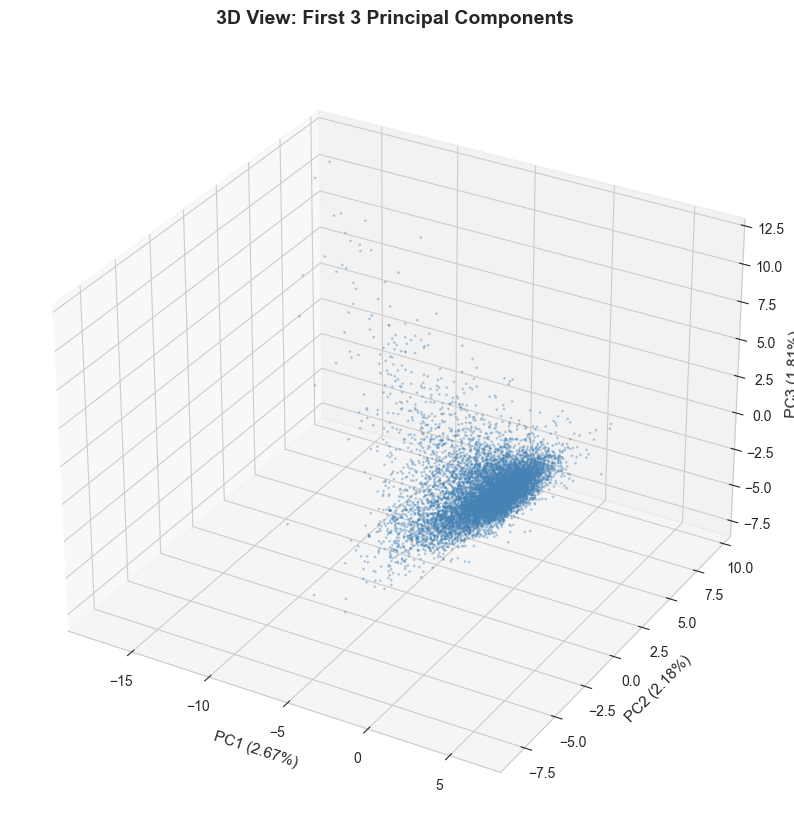


✅ 3D PC visualization saved: 05_pca_3d_visualization.png


In [34]:
# Create 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot sample
ax.scatter(
    pca_sample['PC1'],
    pca_sample['PC2'],
    pca_sample['PC3'],
    alpha=0.3,
    s=1,
    c='steelblue'
)

ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.2f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.2f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.2f}%)', fontsize=11)
ax.set_title('3D View: First 3 Principal Components',
             fontsize=14, fontweight='bold', pad=20)

plt.savefig(VIZ_DIR / '05_pca_3d_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ 3D PC visualization saved: 05_pca_3d_visualization.png")


---

## 8) Build Final Modeling Matrix

Combine PCA-transformed aisle components with scaled behavioral features to produce the primary clustering matrix.


In [35]:
# Combine PCA components with scaled behavioral features
# Use axis=1 for horizontal concatenation (column-wise)
final_matrix: pd.DataFrame = pd.concat(
    [pca_df_final, scaled_behavioral],
    axis=1
)

print(f"Final clustering matrix:")
print(f"   Shape: {final_matrix.shape}")
print(f"   PCA components: {len(pca_df_final.columns)}")
print(f"   Behavioral features: {len(scaled_behavioral.columns)}")
print(f"   Total features: {len(final_matrix.columns)}")

# Validation
assert len(final_matrix.columns) == N_COMPONENTS + len(behavioral_features), "Feature count mismatch!"
assert len(final_matrix) == len(feature_matrix), "Row count mismatch!"
assert final_matrix.isnull().sum().sum() == 0, "NaN values in final matrix!"

print(f"\n✅ Final matrix validation passed")

# Display sample
print(f"\nSample of final matrix:")
print(final_matrix.head())

print(f"\nColumn breakdown:")
print(f"   Columns 1-50:  PC1-PC50 (aisle patterns)")
print(f"   Columns 51-64: Behavioral features")
print(f"\nBehavioral features included:")
for feat in behavioral_features:
    print(f"   - {feat}")

Final clustering matrix:
   Shape: (182223, 64)
   PCA components: 50
   Behavioral features: 14
   Total features: 64

✅ Final matrix validation passed

Sample of final matrix:
              PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
user_id                                                                         
1       -1.966572 -3.438465 -1.294394  0.598293 -1.819745 -2.076370 -0.905213   
2       -0.227792 -1.457350 -1.692038 -1.261772  0.858546 -0.613938 -0.510997   
3        0.741597 -1.590246 -0.164045 -1.461907  0.654644  0.298143 -0.276263   
4       -2.046022 -0.417273 -0.646590  2.274137  3.116213  0.449983 -0.612009   
5        2.018066 -0.511660  1.252119 -0.296485  0.283839  0.424177  0.324427   

              PC8       PC9      PC10  ...  cv_days_between_orders  \
user_id                                ...                           
1       -1.606740 -2.002916  0.191963  ...               -0.484284   
2       -0.592287 -0.567731  0.459473  ...  


### 8.1 Rigor Check: Correlation-Pruned Behavioral Variant

Create a second matrix that drops one feature from each strongly correlated behavioral pair.
This gives Notebook 04 a fair A/B test:
- **Full matrix**: maximum signal retention
- **Pruned matrix**: reduced redundancy and simpler model input


In [36]:

print('=' * 70)
print('RIGOR CHECK: FULL VS PRUNED BEHAVIORAL MATRIX')
print('=' * 70)

prune_candidates = ['pct_reordered_products', 'max_basket_size', 'unique_aisles']
drop_cols = [c for c in prune_candidates if c in scaled_behavioral.columns]
keep_cols = [c for c in scaled_behavioral.columns if c not in drop_cols]

scaled_behavioral_pruned = scaled_behavioral[keep_cols].copy()
final_matrix_pruned = pd.concat([pca_df_final, scaled_behavioral_pruned], axis=1)

print()
print('Pruning decisions:')
for c in drop_cols:
    print(f'  - dropped: {c}')
print()
print(f'Behavioral features (full):   {scaled_behavioral.shape[1]}')
print(f'Behavioral features (pruned): {scaled_behavioral_pruned.shape[1]}')
print(f'Final matrix (full):          {final_matrix.shape[1]} features')
print(f'Final matrix (pruned):        {final_matrix_pruned.shape[1]} features')

def corr_summary(df):
    corr = df.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool)).stack()
    return {
        'n_features': df.shape[1],
        'mean_abs_corr': float(upper.mean()) if len(upper) else 0.0,
        'max_abs_corr': float(upper.max()) if len(upper) else 0.0,
    }

full_stats = corr_summary(scaled_behavioral)
pruned_stats = corr_summary(scaled_behavioral_pruned)

ablation_report = pd.DataFrame([
    {'matrix': 'full_behavioral_block', **full_stats},
    {'matrix': 'pruned_behavioral_block', **pruned_stats},
])

print()
print('Correlation summary (behavioral block):')
print(ablation_report.to_string(index=False, float_format=lambda x: f'{x:.4f}'))


RIGOR CHECK: FULL VS PRUNED BEHAVIORAL MATRIX

Pruning decisions:
  - dropped: pct_reordered_products
  - dropped: max_basket_size
  - dropped: unique_aisles

Behavioral features (full):   14
Behavioral features (pruned): 11
Final matrix (full):          64 features
Final matrix (pruned):        61 features

Correlation summary (behavioral block):
                 matrix  n_features  mean_abs_corr  max_abs_corr
  full_behavioral_block          14         0.2241        0.9126
pruned_behavioral_block          11         0.1785        0.7193



---

## 9) Save Outputs

Persist matrices, models, diagnostics, and summary artifacts for Notebook 04.


In [37]:

print('Saving all outputs...')
print()

final_matrix.to_parquet(OUTPUT_DIR / 'final_clustering_matrix.parquet')
print(f"✅ Saved: final_clustering_matrix.parquet ({final_matrix.shape[0]:,} × {final_matrix.shape[1]})")

if 'final_matrix_pruned' in locals():
    final_matrix_pruned.to_parquet(OUTPUT_DIR / 'final_clustering_matrix_pruned.parquet')
    print(f"✅ Saved: final_clustering_matrix_pruned.parquet ({final_matrix_pruned.shape[0]:,} × {final_matrix_pruned.shape[1]})")

with open(OUTPUT_DIR / 'pca_model.pkl', 'wb') as f:
    pickle.dump(pca_final, f)
print('✅ Saved: pca_model.pkl')

with open(OUTPUT_DIR / 'scaler_model.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print('✅ Saved: scaler_model.pkl')

print('✅ Already saved: pca_loadings.csv')
print('✅ Already saved: feature_importance.csv')

if 'ablation_report' in locals():
    ablation_report.to_csv(OUTPUT_DIR / 'ablation_behavioral_pruning.csv', index=False)
    print('✅ Saved: ablation_behavioral_pruning.csv')

summary = {
    'original_features': len(feature_matrix.columns),
    'aisle_features': len(aisle_features),
    'behavioral_features_full': len(scaled_behavioral.columns),
    'behavioral_features_pruned': int(len(scaled_behavioral_pruned.columns)) if 'scaled_behavioral_pruned' in locals() else None,
    'pca_components': N_COMPONENTS,
    'final_features_full': len(final_matrix.columns),
    'final_features_pruned': int(len(final_matrix_pruned.columns)) if 'final_matrix_pruned' in locals() else None,
    'variance_explained': float(pca_final.explained_variance_ratio_.sum()),
    'dimensionality_reduction': float(1 - N_COMPONENTS / len(aisle_features)),
    'sklearn_version': sklearn.__version__,
    'random_seed': RANDOM_SEED,
}

with open(OUTPUT_DIR / 'transformation_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print('✅ Saved: transformation_summary.json')

print()
print('Summary snapshot:')
for key, value in summary.items():
    if isinstance(value, float):
        print(f'   {key}: {value:.4f}')
    else:
        print(f'   {key}: {value}')

print()
print(f'📁 All outputs saved to: {OUTPUT_DIR}')
print(f'📊 All visualizations saved to: {VIZ_DIR}')
print('✅ Notebook 03 complete!')


Saving all outputs...

✅ Saved: final_clustering_matrix.parquet (182,223 × 64)
✅ Saved: final_clustering_matrix_pruned.parquet (182,223 × 61)
✅ Saved: pca_model.pkl
✅ Saved: scaler_model.pkl
✅ Already saved: pca_loadings.csv
✅ Already saved: feature_importance.csv
✅ Saved: ablation_behavioral_pruning.csv
✅ Saved: transformation_summary.json

Summary snapshot:
   original_features: 149
   aisle_features: 135
   behavioral_features_full: 14
   behavioral_features_pruned: 11
   pca_components: 50
   final_features_full: 64
   final_features_pruned: 61
   variance_explained: 0.4668
   dimensionality_reduction: 0.6296
   sklearn_version: 1.6.1
   random_seed: 42

📁 All outputs saved to: data/processed_features
📊 All visualizations saved to: visualizations
✅ Notebook 03 complete!


In [38]:
print('='*70)
print('INTERPRETATION SANITY CHECK (NOTEBOOK 03)')
print('='*70)

cum = cumulative_variance
for k in [10, 20, 30, 40, 50]:
    if k <= len(cum):
        print(f'Cumulative variance @ {k} PCs: {cum[k-1]*100:.2f}%')

if len(cum) >= 50:
    print(f'Incremental gain 40 -> 50 PCs: {(cum[49]-cum[39])*100:.2f}%')

hit90 = any(cum >= 0.90)
hit95 = any(cum >= 0.95)
print(f'Reaches 90% variance in available PCs: {hit90}')
print(f'Reaches 95% variance in available PCs: {hit95}')

print(f'Final matrix (full): {final_matrix.shape[1]} features')
if 'final_matrix_pruned' in locals():
    print(f'Final matrix (pruned): {final_matrix_pruned.shape[1]} features')

print('Recommendation: avoid hardcoded elbow/plateau claims; cite these values directly.')


INTERPRETATION SANITY CHECK (NOTEBOOK 03)
Cumulative variance @ 10 PCs: 14.93%
Cumulative variance @ 20 PCs: 23.92%
Cumulative variance @ 30 PCs: 31.86%
Cumulative variance @ 40 PCs: 39.38%
Cumulative variance @ 50 PCs: 46.68%
Incremental gain 40 -> 50 PCs: 7.30%
Reaches 90% variance in available PCs: True
Reaches 95% variance in available PCs: True
Final matrix (full): 64 features
Final matrix (pruned): 61 features
Recommendation: avoid hardcoded elbow/plateau claims; cite these values directly.



---

## Final Summary (Notebook 03) + What Comes Next

### Executive Recap
This notebook standardizes features, runs PCA on aisle features, and prepares clustering matrices.

### Read This With The Sanity Cell
Run **INTERPRETATION SANITY CHECK (NOTEBOOK 03)** and cite those values directly (especially cumulative variance and component tradeoffs).

### What is stable regardless of rerun
- Transform pipeline (scaler + PCA) and saved artifacts.
- Full vs pruned matrix generation for sensitivity testing.

### What can move across reruns
- Exact cumulative variance at specific component counts.
- Incremental gain from 40 -> 50 components.

### Notebook 04 plan
1. Evaluate clustering on full matrix.
2. Evaluate clustering on pruned matrix.
3. Compare quality metrics (silhouette, Davies-Bouldin, stability, and balance).
4. Keep the simpler representation unless full matrix gives clear improvement.
